In [5]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 데이터 로드

In [6]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

# 데이터 정제

## 한글과 공백만 남겨두고 모두 제거

In [7]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
test_data['document'] = test_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

## 결측치 데이터 삭제

In [8]:
print("train_data 널값 존재 여부 : "+ str(train_data.isnull().values.any())) # 널값 존재 확인
print(train_data.isnull().sum())
print("=====================")
print("test_data 널값 존재 여부 : "+ str(test_data.isnull().values.any())) # 널값 존재 확인
print(test_data.isnull().sum())


train_data 널값 존재 여부 : True
id          0
document    5
label       0
dtype: int64
test_data 널값 존재 여부 : True
id          0
document    3
label       0
dtype: int64


In [9]:
train_data['document'].replace('', np.nan, inplace=True)
train_data = train_data.dropna(how = 'any') # 널값 존재 행 제거
print(train_data.isnull().sum())
print("train_data 널값 존재 여부 : "+ str(train_data.isnull().values.any())) # 널값 존재 확인
print("=====================")
test_data['document'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how = 'any') # 널값 존재 행 제거
print(test_data.isnull().sum())
print("test_data 널값 존재 여부 : "+ str(test_data.isnull().values.any())) # 널값 존재 확인

id          0
document    0
label       0
dtype: int64
train_data 널값 존재 여부 : False
id          0
document    0
label       0
dtype: int64
test_data 널값 존재 여부 : False


## 중복제거

In [10]:
print("train_data 총건수 : " + str(len(train_data)))
print("train_data document 중복제외건수(유니크)) : " + str(train_data['document'].nunique()))
print("train_data label 중복제외건수(유니크)) : " + str(train_data['label'].nunique()))
print("================================")
print("test_data 총건수 : " + str(len(test_data)))
print("test_data document 중복제외건수(유니크)) : " + str(test_data['document'].nunique()))
print("test_data label 중복제외건수(유니크)) : " + str(test_data['label'].nunique()))

train_data 총건수 : 149186
train_data document 중복제외건수(유니크)) : 143681
train_data label 중복제외건수(유니크)) : 2
test_data 총건수 : 49726
test_data document 중복제외건수(유니크)) : 48417
test_data label 중복제외건수(유니크)) : 2


In [11]:
train_data.drop_duplicates(subset=['document'], inplace=True) # train_data document 중복제거 수행
test_data.drop_duplicates(subset=['document'], inplace=True) # test_data document 중복제거 수행

In [12]:
print('train_data 중복제거한 총건수 :',len(train_data))
print('test_data 중복제거한 총건수 :',len(test_data))

train_data 중복제거한 총건수 : 143681
test_data 중복제거한 총건수 : 48417


## 불용어제거

In [13]:
okt = Okt()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] #불용어

## train_data 불용어 제거

In [14]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_train.append(temp_X)

## test_data 불용어 제거

In [15]:
X_test = []
for sentence in test_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True)
    temp_X = [word for word in temp_X if not word in stopwords]
    X_test.append(temp_X)

# 토큰화

In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

## 정수인코딩

In [17]:
threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 43752
등장 빈도가 2번 이하인 희귀 단어의 수: 24340
단어 집합에서 희귀 단어의 비율: 55.631742548912044
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.8757278609673573


In [18]:
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 19414


In [19]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [20]:
y_train = np.array(train_data['label'])
y_test = np.array(test_data['label'])

In [21]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [22]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

143651
143651


D:\Anaconda3\envs\nlp\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


## 패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.11225818128659


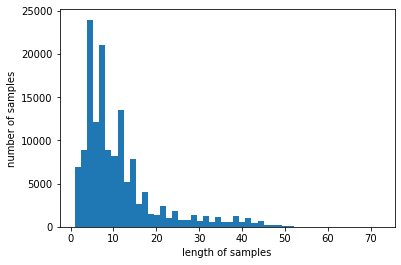

In [23]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [25]:
max_len = 30
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 94.01187600504


In [26]:
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# LSTM 모델 학습

In [27]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [28]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [29]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [30]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
1916/1916 [==============================] - 72s 37ms/step - loss: 0.4413 - acc: 0.7904 - val_loss: 0.3581 - val_acc: 0.8428

Epoch 00001: val_acc improved from -inf to 0.84278, saving model to best_model.h5
Epoch 2/15
1916/1916 [==============================] - 73s 38ms/step - loss: 0.3303 - acc: 0.8555 - val_loss: 0.3344 - val_acc: 0.8541

Epoch 00002: val_acc improved from 0.84278 to 0.85406, saving model to best_model.h5
Epoch 3/15
1916/1916 [==============================] - 75s 39ms/step - loss: 0.2997 - acc: 0.8720 - val_loss: 0.3329 - val_acc: 0.8543

Epoch 00003: val_acc improved from 0.85406 to 0.85434, saving model to best_model.h5
Epoch 4/15
1916/1916 [==============================] - 78s 41ms/step - loss: 0.2814 - acc: 0.8831 - val_loss: 0.3269 - val_acc: 0.8588

Epoch 00004: val_acc improved from 0.85434 to 0.85879, saving model to best_model.h5
Epoch 5/15
1916/1916 [==============================] - 76s 40ms/step - loss: 0.2686 - acc: 0.8898 - val_loss: 0.33

In [31]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1514/1514 [==============================] - 10s 7ms/step - loss: 0.3409 - acc: 0.8541

 테스트 정확도: 0.8541


# Word2Vec 모델 생성

In [44]:
from gensim.models import Word2Vec

In [40]:
train_data = pd.read_table('ratings.txt') # 전체 리뷰 문장 로드

In [41]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

In [42]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


In [43]:
tokenized_data = []
for sentence in train_data['document']:
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    tokenized_data.append(temp_X)

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 10.716703668146726


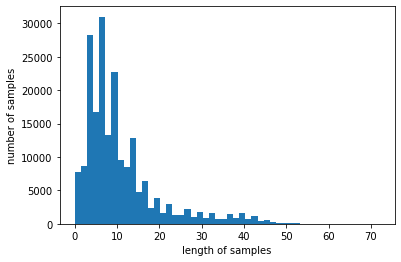

In [45]:
print('리뷰의 최대 길이 :',max(len(l) for l in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(s) for s in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [46]:
model = Word2Vec(sentences = tokenized_data, size = 100, window = 5, min_count = 5, workers = 4, sg = 0) # CBOW 

In [47]:
model.save('word2vec.model') # 모델저장

In [48]:
model = Word2Vec.load('word2vec.model') # 모델불러오기

In [49]:
# 연관분석 단어 predict
def sentiment_predict2(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    if(score > 0.5):        
        result = 1 # 긍정
    else:        
        result = 0 # 부정
    return result

In [50]:
def sentiment_predict(new_sentence):
    cnt = 0
    ecnt = 0
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거        
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
    out = 0
    cntT = 0;
    cntF = 0;
    if(score > 0.5):        
        if((score*100) >=55):
            out = 1
        else:            
            for word in new_sentence:
                try:
                    val = model.wv.most_similar(word, topn=5)
                    for wd in val:
                        val2 = str(wd).replace('[','').replace(']','').replace('(','').replace(')','').replace('\'','').replace('\'','').split(',')
                        if sentiment_predict2(val2)==1:
                            cntT+=1
                        else:
                            cntF+=1
                except:
                    continue
            if cntT>=cntF:
                out = 1
            else:
                out = 0
    else:        
        if(((1 - score) * 100) >=55):
            out = 0
        else:            
            for word in new_sentence:
                try:
                    val = model.wv.most_similar(word, topn=5)
                    for wd in val:
                        val2 = str(wd).replace('[','').replace(']','').replace('(','').replace(')','').replace('\'','').replace('\'','').split(',')
                        if sentiment_predict2(val2)==1:
                            cntT+=1
                        else:
                            cntF+=1
                except:
                    continue
            if cntT>cntF:
                out = 1
            else:
                out = 0
    return out

In [51]:
data = pd.read_csv('ko_data.csv', encoding='cp949')

In [52]:
cols = ['Id','Predicted']
listdict = []

In [53]:
for index, row in data.iterrows():
    result = sentiment_predict(row["Sentence"])
    rowId = row["Id"]
    listdict.append({'Id':str(rowId),'Predicted':str(result)})
    output = pd.DataFrame(listdict,columns=cols)

In [54]:
output.to_csv('sample.csv')